In [8]:
import sys
print(sys.path)
print(sys.executable)
print(sys.prefix)

['/Users/greddy/Dropbox (Harvard University)/Curriculum/automated-curriculum-learning-main/binary_env/paper_fig/notebook', '/Users/greddy/miniconda3/envs/generic/lib/python39.zip', '/Users/greddy/miniconda3/envs/generic/lib/python3.9', '/Users/greddy/miniconda3/envs/generic/lib/python3.9/lib-dynload', '', '/Users/greddy/miniconda3/envs/generic/lib/python3.9/site-packages', '../', '../../', '../', '../', '../../', '../']
/Users/greddy/miniconda3/envs/generic/bin/python
/Users/greddy/miniconda3/envs/generic


In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib

import sys
sys.path.append('../')
sys.path.append('../../')
#sys.path.insert(0, '/Users/greddy/miniconda3/envs/generic/lib/python3.9/site-packages')
#if '/Users/greddy/Projects/Soaring_Exp/gym' in sys.path:
#    sys.path.remove('/Users/greddy/Projects/Soaring_Exp/gym')

from common import *
from env import *

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

%load_ext autoreload
%autoreload 2


# The next two functions are common code that make all the trajectory plots. Updating
# them here will update them everywhere
def plot_traj_and_qr(traj, qr, eps, N, n_step=1, ax=None, save_path=None):
    if type(ax) == type(None):
        plt.clf()
        plt.gcf().set_size_inches(8, 3)
        ax = plt.gca()

    qr = np.array(qr)
    qr = np.flip(qr.T, axis=0) + eps
    im = ax.imshow(qr, aspect='auto', vmin=0, vmax=10)

    ticks = np.arange(N) * n_step
    ax.set_yticks(ticks, np.flip(np.arange(N) + 1))
    ax.set_ylabel('N')
    ax.set_xlabel('Steps')
    ax.set_title(fr'$\epsilon = {eps}$')

    plt.colorbar(im, ax=ax)

    adj = -0.425 if n_step == 1 else 2.75
    ax.plot(10 * n_step - np.array(traj)[1:] + adj, color='red')
    ax.set_xlim((0, len(traj) - 1.5))

    plt.gcf().tight_layout()

    if save_path:
        plt.savefig(save_path)
        

def plot_traj_slices(qr, eps, ax=None, n_steps=1):
    qr = np.array(qr) + eps
    if ax == None:
        ax = plt.gca()

    for i in [0, 2, 4, 7, 9]:
        ax.plot(qr[:,i*n_steps + n_steps - 1], label=f'N = {i+1}', alpha=i/15 + 0.35, color='C0')

    ax.set_xlabel('Step')
    ax.set_ylabel(r'Q value')
    ax.legend()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
fig_dir = Path('fig')   # directory that will contained saved figures
if not fig_dir.exists():
    fig_dir.mkdir()

In [11]:
prefix = "../../../../Plots/"

# Incremental

## Measuring success rate as a function of $\varepsilon$ 

In [12]:
np.random.seed(0)
eps = np.linspace(-4, 2, num=15)
N = 10

all_lens = []

n_iters = 100

for _ in range(n_iters):
    trajs = [run_exp_inc(eps=e, goal_length=N) for e in eps]
    traj_lens = [len(t) for t, _ in trajs]
    all_lens.append(traj_lens)

all_lens = np.array(all_lens)

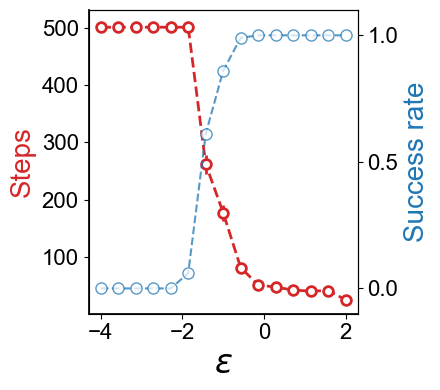

In [13]:
mean = np.mean(all_lens, axis=0)
sd_err = np.std(all_lens, axis=0) / np.sqrt(n_iters)

succ = np.mean(all_lens < 500, axis=0)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
axis.errorbar(eps, traj_lens, fmt='o--', yerr=sd_err, mfc = 'w',mew = 2, lw = 2, ms = 7, color = 'C3')

axis.set_xlabel(r'$\varepsilon$', fontsize = 24)
axis.set_ylabel('Steps', fontsize = 20, color = 'C3')
axis.tick_params(labelsize = 16)

ax = axis.twinx()
ax.plot(eps,succ,'o--', mfc = 'w', ms = 8, alpha = 0.75 )
ax.set_ylabel('Success rate', fontsize = 20, color = 'C0')
ax.set_yticks([0,0.5,1])
ax.tick_params(labelsize = 16)
ax.set_ylim(-0.1,1.1)

axis.spines['top'].set_visible(1.25)
axis.spines['right'].set_visible(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
fig.tight_layout()
fig.savefig(prefix + "fig2_inc_eps.pdf")
plt.show()

## Measuring success rate as a function of $N$ and $\varepsilon$ 

In [144]:
Ns = np.arange(5,45,5)
niter = 20
epss = np.linspace(-3,1,15)
eps = -1
msteps = 3000
lr = 0.1

success = np.zeros((len(Ns),len(epss),niter))
for ii,N in enumerate(Ns):
    print(N)
    for ie,eps in enumerate(epss):
        for i in range(niter):
            np.random.seed(i)
            traj, info = run_exp_inc(eps=eps, goal_length=N, lr = lr, max_steps = msteps)
            qrs = np.array(info['qr'])
            success[ii,ie,i] = len(qrs) < msteps

5
10
15
20
25
30
35
40


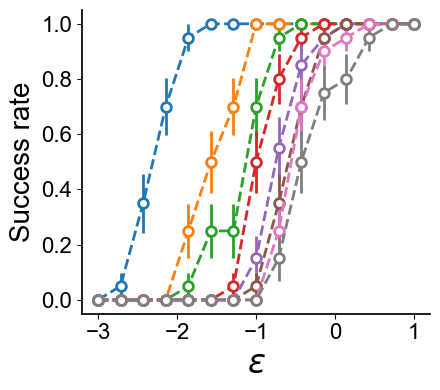

In [145]:
mean = np.mean(success, axis=-1)
sd_err = np.std(success, axis=-1) / np.sqrt(niter)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
for i in range(len(Ns)):
    axis.errorbar(epss, mean[i], fmt='o--', yerr=sd_err[i], mfc = 'w',mew = 2, lw = 2, ms = 7, color = 'C%d'%i)

axis.set_xlabel(r'$\varepsilon$', fontsize = 24)
axis.set_ylabel('Success rate', fontsize = 20)
axis.tick_params(labelsize = 16)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
fig.tight_layout()
#fig.savefig("../../../../Plots/fig2_inc_eps.pdf")
plt.show()

## Measuring success rate as a function of $N$ and $\alpha$ 

In [101]:
Ns = np.arange(5,25,3)
niter = 20
eps = -1.5
msteps = 2500
lrs = np.logspace(np.log10(0.01),np.log10(0.1),10)
#lrs=np.array([0.1])

success = np.zeros((len(Ns),len(lrs),niter))
for ii,N in enumerate(Ns):
    print(N)
    for ie,lr in enumerate(lrs):
        for i in range(niter):
            np.random.seed(i)
            traj, info = run_exp_inc(eps=eps, goal_length=N, lr = lr, max_steps = msteps)
            qrs = np.array(info['qr'])
            success[ii,ie,i] = len(qrs) < msteps

5
8
11
14
17
20
23


/var/folders/_q/41h8mmmd09dbwb8tg4c6rr400000gp/T/ipykernel_40757/228376063.py:7: RuntimeWarning: divide by zero encountered in log10
  axis.plot(Ns**2, np.log10(mean[:,i]), 'o--', mfc = 'w',mew = 2, lw = 2, ms = 7, color = 'C%d'%i)


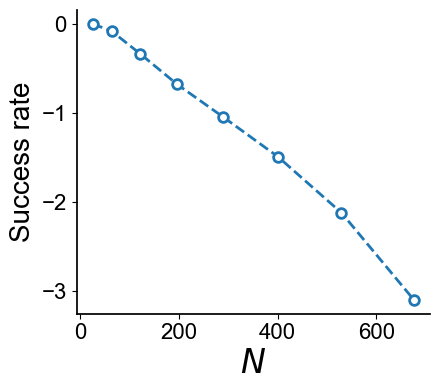

In [169]:
mean = np.mean(success, axis=-1)
sd_err = np.std(success, axis=-1) / np.sqrt(niter)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))
for i in range(len(lrs)):
    axis.plot(Ns, np.log10(mean[:,i]), 'o--', mfc = 'w',mew = 2, lw = 2, ms = 7, color = 'C%d'%i)

axis.set_xlabel(r'$N$', fontsize = 24)
axis.set_ylabel('Success rate', fontsize = 20)
axis.tick_params(labelsize = 16)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
fig.tight_layout()
#fig.savefig("../../../../Plots/fig2_inc_eps.pdf")
plt.show()

## Visualizing the $q$ dynamics 

131


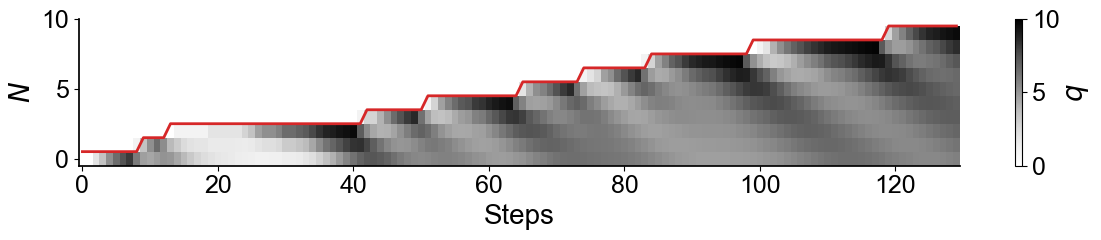

5000


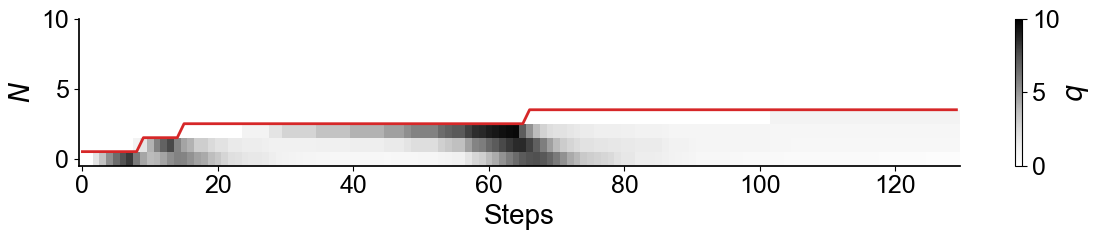

In [ ]:
np.random.seed(0)
N = 10
msteps = 5000
epss = [-1.5,-1.8]
for ie,eps in enumerate(epss):
    traj, info = run_exp_inc(eps=eps, goal_length=N, T=3, lr = 0.1, max_steps = msteps)

    qrs = np.array(info['qr'])
    levels = np.array(traj)-0.5
    print(len(qrs))

    plt.close("all")
    fig,axis= plt.subplots(1,1,figsize = (12,2.5))
    im = axis.imshow((qrs.T)[:,:130], origin = 'lower',aspect = 'auto', vmin = 0, vmax = 10, cmap = 'Greys')
    axis.plot(levels[:130],'C3-',lw=2)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_linewidth(1.25)
    axis.spines['left'].set_linewidth(1.25)
    axis.tick_params(labelsize = 18)
    axis.set_yticks([0,5,10])
    axis.set_ylabel(r"$N$", fontsize = 20)
    axis.set_xlabel(r"Steps", fontsize = 20)

    cb = fig.colorbar(mappable = im)
    cb.ax.tick_params(labelsize=18)
    cb.set_ticks([0,5,10])
    cb.set_label("$q$", fontsize = 20)
    fig.tight_layout()
    fig.savefig(prefix +  "fig2_qdyn_hmap_%d.pdf"%ie)
    plt.show()

#plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_failure_qr.png')

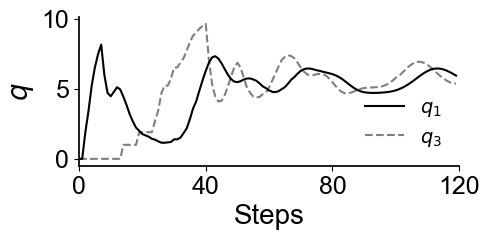

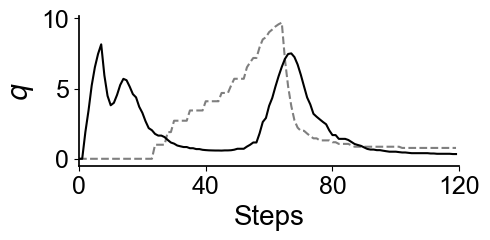

In [24]:
np.random.seed(0)
N = 10
msteps = 5000
epss = [-1.5,-1.8]
for ie,eps in enumerate(epss):
    traj, info = run_exp_inc(eps=eps, goal_length=N, T=3, lr = 0.1, max_steps = msteps)
    qrs = np.array(info['qr'])

    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (5,2.5))
    axis.plot(qrs[:120,0],'k-',lw=1.5,label = r"$q_1$")
    axis.plot(qrs[:120,2],'k--',lw = 1.5,alpha = 0.5,label = r"$q_3$")
    if ie == 0:
        axis.legend(fontsize = 14, frameon = False, loc = 4)
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_linewidth(1.25)
    axis.spines['left'].set_linewidth(1.25)
    axis.tick_params(labelsize = 18)
    axis.set_yticks([0,5,10])
    axis.set_xlim(0,120)
    axis.set_xticks([0,40,80,120])
    axis.set_ylabel(r"$q$", fontsize = 20)
    axis.set_xlabel(r"Steps", fontsize = 20)
    fig.tight_layout()
    fig.savefig( prefix +  "fig2_qdyn_waves_%d.pdf"%ie)
    plt.show()

# POMCP

Download dataframe file (`pomcp.pkl`) on the Google drive: https://drive.google.com/drive/u/1/folders/1yQ0WoPIlG-XdAXXAZLD5-Qz-3NpMtTXg

In [14]:
df = pd.read_pickle('pomcp.pkl')

Individual rows can be plotted much in the same way as above. Below is an example of three different runs:

164


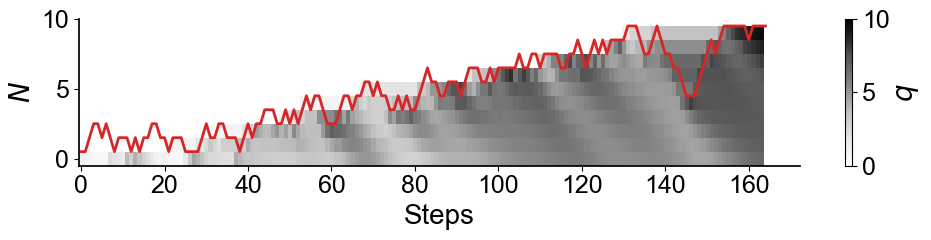

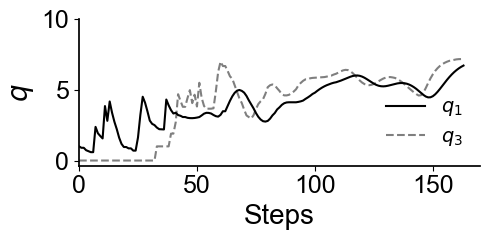

In [22]:
N = 10
eps = -2
ie = 1
row = df.loc[10]
traj, info = row['runs'][ie], row['info'][ie]

qrs = np.array(info['qr'])
levels = np.array(traj) - 0.5
print(len(qrs))

nsteps = 170


plt.close("all")
fig,axis= plt.subplots(1,1,figsize = (10,2.5))
im = axis.imshow((qrs.T)[:,:nsteps], origin = 'lower',aspect = 'auto', vmin = 0, vmax = 10, cmap = 'Greys')
axis.plot(levels[:nsteps],'C3-',lw=2)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.tick_params(labelsize = 18)
axis.set_yticks([0,5,10])
axis.set_ylabel(r"$N$", fontsize = 20)
axis.set_xlabel(r"Steps", fontsize = 20)

cb = fig.colorbar(mappable = im)
cb.ax.tick_params(labelsize=18)
cb.set_ticks([0,5,10])
cb.set_label("$q$", fontsize = 20)
fig.tight_layout()
fig.savefig(prefix +  "fig3_qdyn_hmap_pomcp_%d.pdf"%ie)
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (5,2.5))
axis.plot(qrs[:nsteps,0],'k-',lw=1.5,label = r"$q_1$")
axis.plot(qrs[:nsteps,2],'k--',lw = 1.5,alpha = 0.5,label = r"$q_3$")
#axis.plot(qrs[:250,4],'k-.',lw = 1.5,alpha = 0.5,label = r"$q_5$")
#if ie == 0:
axis.legend(fontsize = 14, frameon = False, loc = 4)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.tick_params(labelsize = 18)
axis.set_yticks([0,5,10])
axis.set_xlim(0,nsteps)
#axis.set_xticks([0,40,80])
axis.set_ylabel(r"$q$", fontsize = 20)
axis.set_xlabel(r"Steps", fontsize = 20)
fig.tight_layout()
fig.savefig( prefix +  "fig3_qdyn_waves_pomcp_%d.pdf"%ie)
plt.show()

# Adaptive

Individual plots can be made much in the same way as before. Below I plot three different examples assembled into a single image.

251


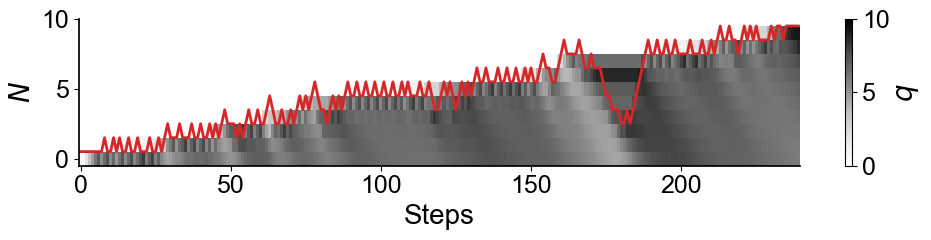

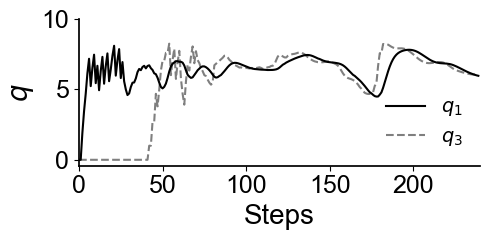

In [26]:
np.random.seed(0)
N = 10
eps = -2
ie = 0
row = df.loc[10]
traj, info = run_adp_exp_disc(eps=eps, goal_length=N)

qrs = np.array(info['qr'])
levels = np.array(traj) - 0.5
print(len(qrs))


plt.close("all")
fig,axis= plt.subplots(1,1,figsize = (10,2.5))
im = axis.imshow((qrs.T)[:,:240], origin = 'lower',aspect = 'auto', vmin = 0, vmax = 10, cmap = 'Greys')
axis.plot(levels[:240],'C3-',lw=2)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.tick_params(labelsize = 18)
axis.set_yticks([0,5,10])
axis.set_ylabel(r"$N$", fontsize = 20)
axis.set_xlabel(r"Steps", fontsize = 20)

cb = fig.colorbar(mappable = im)
cb.ax.tick_params(labelsize=18)
cb.set_ticks([0,5,10])
cb.set_label("$q$", fontsize = 20)
fig.tight_layout()
fig.savefig(prefix +  "fig3_qdyn_hmap_ada_%d.pdf"%ie)
plt.show()

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (5,2.5))
axis.plot(qrs[:240,0],'k-',lw=1.5,label = r"$q_1$")
axis.plot(qrs[:240,2],'k--',lw = 1.5,alpha = 0.5,label = r"$q_3$")
#axis.plot(qrs[:250,4],'k-.',lw = 1.5,alpha = 0.5,label = r"$q_5$")
if ie == 0:
    axis.legend(fontsize = 14, frameon = False, loc = 4)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.tick_params(labelsize = 18)
axis.set_yticks([0,5,10])
axis.set_xlim(0,240)
#axis.set_xticks([0,40,80])
axis.set_ylabel(r"$q$", fontsize = 20)
axis.set_xlabel(r"Steps", fontsize = 20)
fig.tight_layout()
fig.savefig( prefix +  "fig3_qdyn_waves_ada_%d.pdf"%ie)
plt.show()

# Benchmarks

In [27]:
n_iters = 10
Ns = [3, 5, 10]
eps = np.linspace(-3, 2, num=6)
# max_steps = 500

T = 3
lr = 0.1
alpha = 0.1
beta = 1
k = 5

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        cases = [
            Case('Adaptive', run_adp_exp_disc, {'eps': e, 'goal_length': N}, []),
            Case('Incremental', run_exp_inc, {'eps': e, 'goal_length': N}, []),
            Case('Online', run_online, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta}, []),
            Case('Naive', run_naive, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Window', run_window, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Sampling', run_sampling, {'eps': e, 'goal_length': N, 'alpha': alpha, 'k': k}, []),
            Case('Random', run_random, {'eps': e, 'goal_length': N}, []),
            Case('Final', run_final_task_only, {'eps': e, 'goal_length': N}, []),
        ]

        run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
        raw_data.extend(cases)

df_bench = pd.DataFrame(raw_data)
df = pd.concat((df, df_bench), ignore_index=True)

  0%|                                                                                                                                                                             | 0/3 [00:00<?, ?it/s]/Users/greddy/miniconda3/envs/generic/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/greddy/miniconda3/envs/generic/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/greddy/miniconda3/envs/generic/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [28]:
# setting up for benchmark plotting
fig_dir = Path('fig/us_v_matiisen_v_pomcp')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'], decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'traj_lens'])

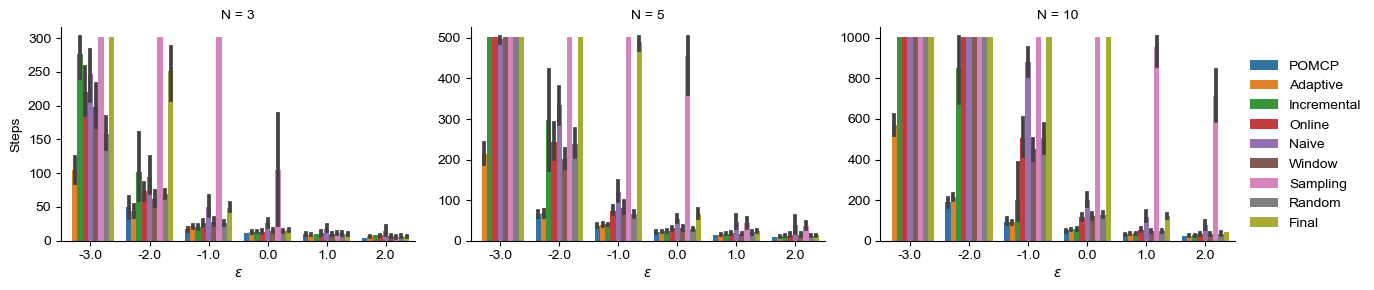

In [29]:
plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

g = sns.catplot(plot_df, x='eps', y='traj_lens', hue='name', col='N', kind='bar', sharey=False, height=3, aspect=1.4)
g.set_axis_labels(f'$\epsilon$', 'Steps')
g.legend.set_title('')

plt.savefig('fig/us_v_matiisen_v_pomcp/seq_benchmarks_conjoined.png')

In [30]:
names = ["Adaptive", "Incremental", "Online", "Naive", "Window","Sampling", "Random", "Final"]
N = 10
df_pomcp = pd.read_pickle('pomcp.pkl')
epss = np.array([-3,-2,-1,0,1,2])
data_bench = np.zeros((len(epss),len(names),10))
for ie,eps in enumerate(epss):
    for ni,n in enumerate(names):
        algo = df_bench.loc[(df_bench["name"] == n)]
        for i in range(len(algo)):
            if algo.iloc[i]['run_params']['goal_length'] == 10 and algo.iloc[i]['run_params']['eps'] == eps:
                row = algo.iloc[i]
                data_bench[ie,ni] = np.array([len(traj) for traj in row['runs']])
    print(data_bench[ie,:])

data_pomcp = np.zeros((5,3))
epss_pomcp=np.array([-2,-1,0,1,2])
for ie,eps in enumerate(epss_pomcp):
    algo = df_pomcp.loc[(df_pomcp["name"] == "POMCP")]
    for i in range(len(algo)):
        if algo.iloc[i]['run_params']['goal_length'] == 10 and algo.iloc[i]['run_params']['eps'] == eps:
            row = algo.iloc[i]
            data_pomcp[ie] = np.array([len(traj) for traj in row['runs']])

[[ 667.  563.  668.  489.  698.  549.  490.  586.  552.  434.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]]
[[ 214.  225.  200.  239.  225.  256.  207.  230.  175.  192.]
 [1001. 1001.  192. 1001. 1001. 1001. 1001. 1001.  317. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001.]
 [1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001. 1001

In [31]:
#Calculate means and SEs
data_bench_means = np.mean(data_bench,axis=2)
data_bench_se = np.std(data_bench,axis=2)/np.sqrt(10)

data_pomcp_means= np.mean(data_pomcp,axis=1)
data_pomcp_se = np.std(data_pomcp,axis=1)/np.sqrt(3)

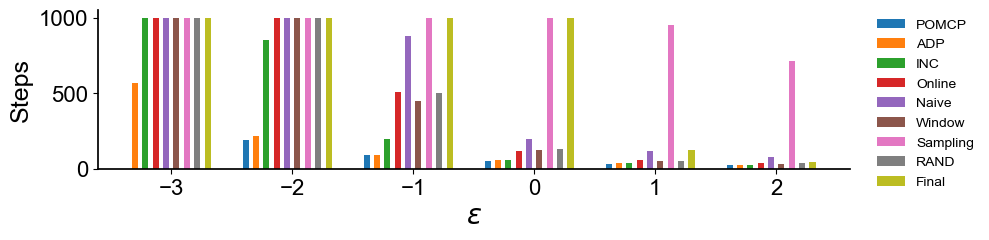

In [38]:

#Plot benchmark histogram
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (10,2.5))

colors = ["C%d"%(i+1) for i in range(8)]
for i in range(6):
    axis.bar(np.linspace(-0.3,0.3,8)+ epss[i],data_bench_means[i], width=0.05, color=colors)

axis.bar(epss_pomcp - 0.38, data_pomcp_means, width = 0.05, color = 'C0', label = 'POMCP')
names_plot = ["ADP", "INC", "Online", "Naive", "Window","Sampling", "RAND", "Final"]
for j in range(8):
    axis.bar([1],[0],color = colors[j],label = names_plot[j])
    
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.tick_params(labelsize = 16)
axis.legend(bbox_to_anchor=(1.02, 1.025), frameon=False, fontsize = 10)
axis.set_ylabel("Steps",fontsize = 18)
axis.set_xlabel(r"$\varepsilon$",fontsize = 20)
fig.tight_layout()
fig.savefig(prefix + "fig3_seqtask_benchmarks.pdf")
plt.show()

In [406]:
Dark2_8.mpl_colors

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]